Este notebook é parte da aula para a disciplina AGA0513
(nina hirata, 2020)

## Linear regression

- Introdução a LR
- Dataset a ser usado nos exemplos
- Solução analítica
- Otimização usando *gradient descent*
- Solução usando a função do scikit-learn

### Introdução

Dado um *dataset* $\{(\mathbf{x}^{(1)}, y^{(1)}), \dots ,(\mathbf{x}^{(N)}, y^{(N)})\}$ com $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$ e $y^{(i)} \in \mathbb{R}$, desejamos aproximar uma função *target* desconhecida $f:\mathbb{R}^{d} \rightarrow \mathbb{R}$ (lembre-se que $y^{(i)} =f(\mathbf{x}^{(i)})$) por meio de um modelo linear $h$:
$$
h(\mathbf{x}; \mathbf{w}, b) = \mathbf{w}^\top  \mathbf{x} + b
$$

A função $h$ é uma transformação linear de $\mathbf{x}$. Usamos a notação $h(\mathbf{x}; \mathbf{w}, b)$ para deixar claro que   $h$ é um modelo paramétrico, ou seja, ele é definido pelos parâmetros  $\mathbf{w}$ e $b$. O vetor $\mathbf{w}$ é comumente chamado de vetor de pesos e controla o efeito de cada *feature* na predição.

Podemos simplificar a notação adicionando uma coordenada artificial com valor igual a 1 às observações $\mathbf{x}^{(i)}$ (com isso, agora as observações $\mathbf{x}^{(i)}$ pertencem a $\mathbb{R}^{d+1}$ e $b$ é o componente em $\mathbf{w}$, também estendido, associado a essa coordenada artificial):

$$
h(\mathbf{x}^{(i)}; \mathbf{w}) = \hat{y}^{(i)} = \mathbf{w}^\top  \mathbf{x}^{(i)}
$$


O que queremos então é determinar o vetor de pesos $\mathbf{w}$ de forma que a predição $\hat{y}^{(i)}$ seja o mais próximo possível de  $y^{(i)}$ (erro mínimo), de acordo com uma métrica de erro. Adotando o   *mean square error* (MSE) como tal métrica, temos a seguinte função de custo:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

Assim, a tarefa de determinar uma função $h$ que seja próxima à função $f$ (lembre-se que $f$ é desconhecida, a menos de seu valor em alguns pontos) é reduzida à tarefa de encontrar o vetor $\mathbf{w}$ que minimiza a função de custo $J(\mathbf{w})$.


### *Dataset* a ser usado nos exemplos

Vamos usar o *Boston Housing Prices*, que está disponível por exemplo no `sklearn`, como mostrado abaixo. Uma descrição desse *dataset* pode ser visto em https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html .
Para simplificar a visualização, usaremos apenas uma variável de *input*  (i.e., trataremos com dados tal que $d=1$), LSTAT, para predizer o *output* (preço do imóvel em $1000s).


#### Imports e funções auxiliares

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

# função que será usada mais adiante
def simple_step_plot(ylist, yname, title, figsize=(4, 4), labels=None):
    y0 = ylist[0]
    x = np.arange(1, len(y0) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for y in ylist:
        ax.plot(x, y)
    plt.xlabel('step')
    plt.ylabel(yname)
    plt.title(title,
              fontsize=14,
              fontweight='bold')
    plt.grid(True)
    if labels is not None:
        plt.legend(labels,
           loc='upper right')
    plt.show()

#### Leitura do *dataset*

X shape:  (506, 1)
y shape:  (506, 1)


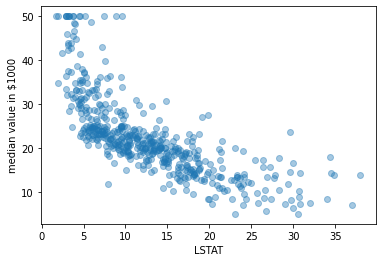

In [2]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

X = df.LSTAT.values.reshape((-1,1))
y = data.target.reshape((-1,1))
print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.scatter(X[:,0], y, alpha=0.4)
plt.xlabel('LSTAT')
plt.ylabel('median value in $1000')

plt.show()

### Solução analítica

Seja $\mathbf{X} \in \mathbb{R}^{N\times d}$ uma matriz cujas linhas são as observações $\mathbf{x}^{(i)}$ do dataset e seja $\mathbf{y} \in \mathbb{R}^{N}$ o vetor consistindo dos valores de $y^{(i)}$. Pode ser mostrado que:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}(\mathbf{X}\mathbf{w} - \mathbf{y})^{T}(\mathbf{X}\mathbf{w} - \mathbf{y})
\end{equation}

Usando conceitos de derivadas matriciais temos que o gradiente de $J(\mathbf{w})$ com respeito a $\mathbf{w}$ é:

\begin{equation}
\nabla J(\mathbf{w}) = \frac{2}{N} (\mathbf{X}^{T}\mathbf{X}\mathbf{w} -\mathbf{X}^{T}\mathbf{y})   
\end{equation}

Assim, quando fazemos $\nabla J(\mathbf{w}) = 0$ temos que:

\begin{equation}
\mathbf{X}^{T}\mathbf{X}\mathbf{w} = \mathbf{X}^{T}\mathbf{y}
\end{equation}

E portanto, 

\begin{equation}
\mathbf{w} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}
\end{equation}

Note que esta solução tem um custo computacional alto e, em particular, quando o número de *features* aumenta, o custo para o cálculo da matriz inversa começa a ficar proibitivo. Veja [este texto  (em inglês)](http://cs229.stanford.edu/notes/cs229-notes1.pdf) para mais detalhes.

In [0]:
# cálculo do vetor de pesos w, dadas a matriz X e o vetor y
def linreg_fit(X, y):
    # Add a bias value 1 as the first coordinate of each vector
    X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)
    
    X_t = X.transpose()
    X_dagger = np.dot(np.linalg.inv(np.dot(X_t, X)), X_t)
    w = np.dot(X_dagger, y)
    
    return w

# cálculo do vetor de predições y_hat, dadas a matriz X
# e o vetor de pesos w
def linreg_predict(X, w):   
    # Add a bias value 1 as the first coordinate of each vector
    if X.shape[1] != w.shape[0]:
        X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)
    y_hat = np.dot(X, w)
    
    return y_hat

Final weight =
 [[34.55384088]
 [-0.95004935]]
Mean squared error: 38.4830
R squared: 0.5441


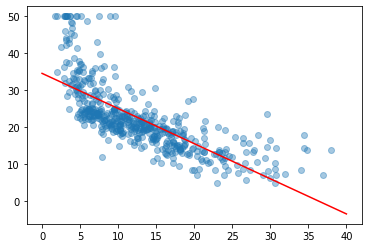

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

# Code to run and show resulst of the analytical solution

w = linreg_fit(X, y)

print("Final weight =\n", w)

prediction = linreg_predict(X, w)

# The mean squared error
print('Mean squared error: %.4f' %mean_squared_error(y, prediction))
# The coefficient of determination: 1 is perfect prediction
print('R squared: %.4f' %r2_score(y, prediction))

plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)
y_reg = w[1]*x_reg + w[0]
plt.plot(x_reg, y_reg, c='r')

plt.show()


### Gradient descent

*Gradient descent* é uma técnica usada para encontrar pontos mínimos de funções que são deriváveis. Aqui usaremos ele para calcular o vetor de pesos $\mathbf{w}$ que minimiza a função custo $J:\mathbb{R}^{1+d} \rightarrow \mathbb{R}$:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

na qual $\hat{y}^{(i)} = \mathbf{w}^T\mathbf{\tilde{x}}^{(i)}$, $\mathbf{\tilde{x}} = (1, x_1, \ldots, x_d)$.

O algoritmo é iterativo. Começa-se, por exemplo, com um ponto aleatório $\mathbf{w}(0) \in \mathbb{R}^{1+d}$ at $t=0$, e a cada iteração $t$ computamos o gradiente de $J$ no ponto $\mathbf{w}(t)$, e então atualizamos $\mathbf{w}(t)$ por um vetor proporcional a   $-\nabla_{\mathbf{w}}J(\mathbf{w})$ (o negativo do gradiente).

- $\mathbf{w}(0) = \mathbf{w}$
- for $t = 0, 1, 2, \dots$ do
    * $\mathbf{w}(t+1) = \mathbf{w}(t) - \eta \nabla J(\mathbf{w}(t))$ 

Conforme visto nos slides,
$\nabla J (\mathbf{w}) = \frac{2}{N} X^T(X\mathbf{w}-\mathbf{y})$.

O coeficiente $\eta \in \mathbb{R}_{\geq}$, conhecido como **learning rate** (taxa de aprendixado), controla o "tamanho" das atualizações. Em geral é um número pequeno como 0.01, ... Esse parâmetro pode ser alterado durante as iterações, porém aqui manteremos fixo durante toda a execução.

In [0]:
# computation of the cost function value
def compute_cost(Xe, y, w):
    J = ((np.dot(Xe,w) - y)**2).mean()

    return J


# computation of the gradient
def compute_wgrad(Xe, y, w):
    N = Xe.shape[0]
    diff = np.dot(Xe,w) - y
    grad = 2/N * np.dot(np.transpose(Xe), diff)

    return grad


# optimization of the cost function:
# application of the gradient descent technique
def batch_gradient_descent(X, y, w, learning_rate=0.001, num_iters=100):
    w_current = w
    if X.shape[1] != w.shape[0]:
        X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)

    cost_history = [compute_cost(X, y, w)]

    for t in range(0, num_iters):
        grad = compute_wgrad(X, y, w_current)
        w_current = w_current - learning_rate * grad
        cost = compute_cost(X, y, w_current)
        cost_history.append(cost)
        if cost == 0:
            break

    return w_current, cost_history 

Initial weight:
 [[20]
 [ 0]]
Final weight:
 [[28.98851059]
 [-0.61592238]]
Mean squared error: 45.9540
R squared: 0.4556


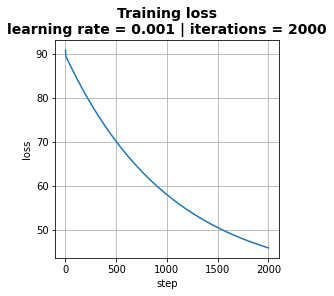

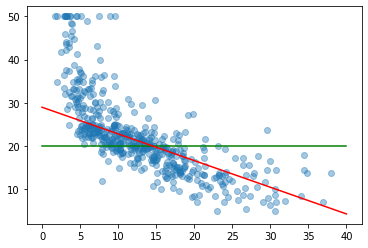

In [6]:
learning_rate = 0.001
initial_w = np.array([[20], [0]])
print("Initial weight:\n", initial_w)
iterations = 2000

w, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)
print("Final weight:\n", w)

# The mean squared error
prediction = linreg_predict(X,w)
print('Mean squared error: %.4f' %mean_squared_error(y, prediction))
# The coefficient of determination: 1 is perfect prediction
print('R squared: %.4f' %r2_score(y, prediction))

simple_step_plot(
    [cost_history], 'loss',
    'Training loss\nlearning rate = {} | iterations = {}'.format(learning_rate, iterations))

plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)
y_reg = initial_w[1]*x_reg + initial_w[0]
plt.plot(x_reg, y_reg, c='g')
y_reg = w[1]*x_reg + w[0]
plt.plot(x_reg, y_reg, c='r')
plt.show()

### Usando a função do Scikit-learn

Weights: 
 [34.55384088] [-0.95004935]
Mean squared error: 38.4830
R squared: 0.5441


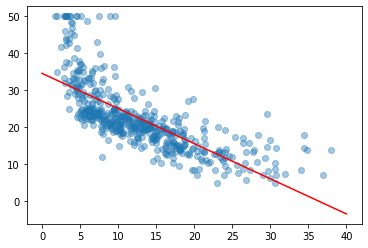

In [7]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

# Make predictions using the testing set
y_pred = regr.predict(X)

# The coefficients
print('Weights: \n', regr.intercept_, regr.coef_[0])
# The mean squared error
print('Mean squared error: %.4f'%mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('R squared: %.4f'%r2_score(y, y_pred))

# Plot outputs
plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)
x_reg = x_reg.reshape((x_reg.shape[0],1))
y_reg = regr.coef_*x_reg + regr.intercept_
plt.plot(x_reg, y_reg, c='r')
plt.show()
